## Airplane delay: Analysis and Prediction
Given historical data about flights in the country, including the delay information that was computed a-posteriori (so the ground truth is available), we want to build a model that can be used to predict how many minutes of delay a flight might experience in the future. This model should provide useful information for the airport to manage better its resources, to minimize the delays and their impact on the journey of its passengers. Alternatively, astute passengers could even use the model to choose the best time for flying, such as to avoid delays.

### 1. Data Pre-Processing
>    #### 1.1 Numerical FEATURES 
>    #### 1.2 Categorical FEATURES 
>    #### 1.3 Semi Categorical FEATURES

### 2. Prediction Models 

### 3. Improvement AND Model Selection

In [1]:
import sys
import json
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
import numpy as np

import sklearn as skl
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = (12,12)
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Data Pre-Processing 
>    ### 1.1 Numerical Features  

First, we import the training and testing data. We will be using pandas library to manipulate and display data.

In [2]:
## Import Data 
analysis_airports = pd.read_csv("/kaggle/input/eurecom-aml-2021-challenge-1/data/airports.csv",engine='python')
analysis_airlines = pd.read_csv("/kaggle/input/eurecom-aml-2021-challenge-1/data/airlines.csv",engine='python')

train_ft = pd.read_csv("/kaggle/input/eurecom-aml-2021-challenge-1/data/train_features.csv",engine='python')
train_label = pd.read_csv("/kaggle/input/eurecom-aml-2021-challenge-1/data/train_targets.csv",engine='python')

test_ft = pd.read_csv("/kaggle/input/eurecom-aml-2021-challenge-1/data/test_features.csv",engine='python')

In [3]:
## Concat Data And Rename 
all_data = pd.concat([train_ft,train_label['ARRIVAL_DELAY']],axis=1)
train_data = all_data.drop(columns=['ARRIVAL_DELAY'],axis=1)

In [4]:
all_data.head(10)

,ID,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,DIVERTED,CANCELLED,CANCELLATION_REASON,ARRIVAL_DELAY
0,5133505,2021,2,14,6,AA,1077,N454AA,BWI,DFW,...,10,832,224.0,168.0,1217,1115,0,0,NaN,-35.0
1,5051259,2021,12,4,5,WN,2510,N656SW,ONT,SMF,...,7,939,80.0,65.0,390,1050,0,0,NaN,-2.0
2,5340710,2021,7,7,2,MQ,3204,N696MQ,DFW,LCH,...,12,2216,73.0,52.0,295,2323,0,0,NaN,-10.0
3,5445255,2021,1,4,7,B6,777,N585JB,BOS,LAS,...,17,2032,363.0,329.0,2381,2308,0,0,NaN,-1.0
4,2473736,2021,6,16,2,WN,4924,N462WN,LAX,OAK,...,8,1822,75.0,54.0,337,1850,0,0,NaN,31.0
5,1605609,2021,2,7,6,EV,6122,N14920,LEX,ORD,...,11,616,94.0,59.0,323,634,0,0,NaN,-6.0
6,4362719,2021,12,17,4,OO,6327,N708SK,MTJ,ORD,...,12,1217,168.0,135.0,1081,1603,0,0,NaN,-25.0
7,4817613,2021,10,13,2,OO,7379,N487CA,14869,10918,...,27,833,50.0,33.0,221,910,0,0,NaN,-1.0
8,693501,2021,11,8,7,AA,1873,N756US,MSY,CLT,...,9,1830,110.0,80.0,651,2115,0,0,NaN,-1.0
9,4336539,2021,9,29,2,AS,487,N525AS,SAN,SEA,...,14,1454,165.0,133.0,1050,1730,0,0,NaN,-17.0


This overview gave us an idea about the data structure we will be using as well as the different fields of the data set. We notice that there are so many features in this data set. So in the first part we will choose the most useful features to keep.

We start by dropping the '__ID__','__YEAR__' column which is totally useless for the prediction.

In [5]:
# Describe Numerical Features
numerical_fts_describe = all_data.describe()

In [6]:
# Delete Semi-Numerical/Semi-Categorical Features
numerical_fts_describe = numerical_fts_describe.drop(['ID','MONTH','DAY','DAY_OF_WEEK','YEAR','CANCELLED','DIVERTED','CANCELLATION_REASON'],axis=1)
numerical_fts = numerical_fts_describe.columns
numerical_fts_describe

,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
count,5.314008e+06,5.314008e+06,5.314008e+06,5.314008e+06,5.314008e+06,5.314008e+06,5.314008e+06,5.314008e+06,5.314008e+06,5.314008e+06,5.314008e+06
mean,2.164483e+03,1.328861e+03,1.335018e+03,9.296022e+00,1.606538e+01,1.357094e+03,1.418975e+02,1.135160e+02,8.244711e+02,1.493188e+03,4.409019e+00
std,1.754631e+03,4.835093e+02,4.964089e+02,3.688786e+01,8.880803e+00,4.979988e+02,7.531133e+01,7.222894e+01,6.086167e+02,5.068811e+02,3.927029e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,1.800000e+01,7.000000e+00,3.100000e+01,1.000000e+00,-8.700000e+01
25%,7.280000e+02,9.160000e+02,9.210000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,8.500000e+01,6.000000e+01,3.730000e+02,1.110000e+03,-1.300000e+01
50%,1.681000e+03,1.325000e+03,1.330000e+03,-2.000000e+00,1.400000e+01,1.343000e+03,1.230000e+02,9.400000e+01,6.500000e+02,1.520000e+03,-5.000000e+00
75%,3.211000e+03,1.730000e+03,1.740000e+03,7.000000e+00,1.900000e+01,1.754000e+03,1.740000e+02,1.440000e+02,1.065000e+03,1.917000e+03,8.000000e+00
max,9.320000e+03,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,7.180000e+02,6.900000e+02,4.983000e+03,2.400000e+03,1.971000e+03


1. Let's look for missing data, and fill Nan numerical Data
2. The range of values of each column varies widely. So normalizing the data is an important step in order to avoid any scaling problem and also to speed up the training process (gradient descent will converge fast)

In [7]:
## Missing Values - Analysis 
all_data[numerical_fts].isna().sum().to_frame()

#'''
#FLIGHT_NUMBER          0
#SCHEDULED_DEPARTURE    0
#DEPARTURE_TIME         0
#DEPARTURE_DELAY        0
#TAXI_OUT               0
#WHEELS_OFF             0
#SCHEDULED_TIME         0
#AIR_TIME               0
#DISTANCE               0
#SCHEDULED_ARRIVAL      0
#ARRIVAL_DELAY          0
#dtype: int64
#'''

#NO MISSING VALUES 

,0
FLIGHT_NUMBER,0
SCHEDULED_DEPARTURE,0
DEPARTURE_TIME,0
DEPARTURE_DELAY,0
TAXI_OUT,0
WHEELS_OFF,0
SCHEDULED_TIME,0
AIR_TIME,0
DISTANCE,0
SCHEDULED_ARRIVAL,0


In [8]:
def fill_nan(df,fts) : # Fill Missing values with the mean 
    df[fts] = df[fts].fillna(df.mean())
    return df

def normalize(df,df_refer,fts) : # Normalizing Data 
    df[fts] = (df[fts] - df_refer[fts].mean())/df_refer[fts].std()
    
def preparation_num(df,df_refer,fts) : 
    # preparation of numerical data 
    # df2 = is the dataframe reference, so while normalizing the test set 
    # we use the mean and variance of the "all_data" ~ Train set 
    df = fill_nan(df,fts)
    normalize(df,df_refer,fts)
    return df 

num_data = all_data[numerical_fts]
num_data = preparation_num(num_data,num_data,numerical_fts)
num_data.head(10)

,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,-0.619779,-1.029683,-1.033458,-0.495990,-0.682977,-1.054408,1.090174,0.754324,0.644953,-0.746108,-1.003533
1,0.196917,-0.824930,-0.811867,-0.197789,-1.020784,-0.839548,-0.821889,-0.671697,-0.713866,-0.874343,-0.163203
2,0.592442,1.822382,1.750537,-0.414663,-0.457772,1.724716,-0.914836,-0.851680,-0.869958,1.637094,-0.366919
3,-0.790755,1.398399,1.369802,0.019084,0.105240,1.355237,2.935846,2.983348,2.557486,1.607501,-0.137738
4,1.572705,0.839981,0.964894,0.805251,-0.908181,0.933549,-0.888280,-0.823990,-0.800949,0.703936,0.677127
5,2.255470,-1.507440,-1.470598,-0.116462,-0.570374,-1.488144,-0.635994,-0.754766,-0.823952,-1.695048,-0.265061
6,2.372303,-0.235489,-0.261917,-0.523099,-0.457772,-0.281313,0.346594,0.297444,0.421495,0.216643,-0.748887
7,2.971860,-1.052433,-1.065690,-0.631536,1.231265,-1.052400,-1.220235,-1.114733,-0.991545,-1.150542,-0.137738
8,-0.166122,1.026120,0.978995,-0.360444,-0.795579,0.949613,-0.423542,-0.464024,-0.285025,1.226741,-0.137738
9,-0.956032,0.240199,0.211483,-0.387554,-0.232567,0.194592,0.306760,0.269754,0.370560,0.467194,-0.545171


### Correlation Matrix

As we can see we have so many features describing the data samples. Probably not all of these feature are importatnt to predict our target which is the delay arrival.

So now, we are going to keep only columns which are relevent to this problem. So let's have a quick look to the correlation between different features using the correlation matrix.

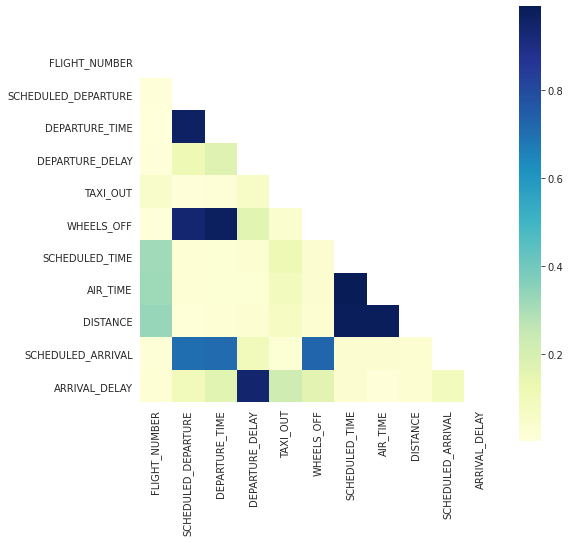

In [9]:
corr_num = num_data[:1000000].corr()
corr_num = np.abs(corr_num)
mask = np.zeros_like(corr_num)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(corr_num, mask=mask, square=True, cmap="YlGnBu")

This heatmap gave us a great overview of our data as well as the relationship between different features.

We notice that there are many darkblue-colored squares: there are obvious correlations such as between __AIR_TIME__, __SCHEDULED_TIME__, __DISTANCE__ and __WHEELS_OFF__, __SCHEDULED_DEPARTURE__, __DEPARTURE_TIME__

These columns give almost the same information, to make sure of the relation between correlated features, let's look to the Scatter plot. 

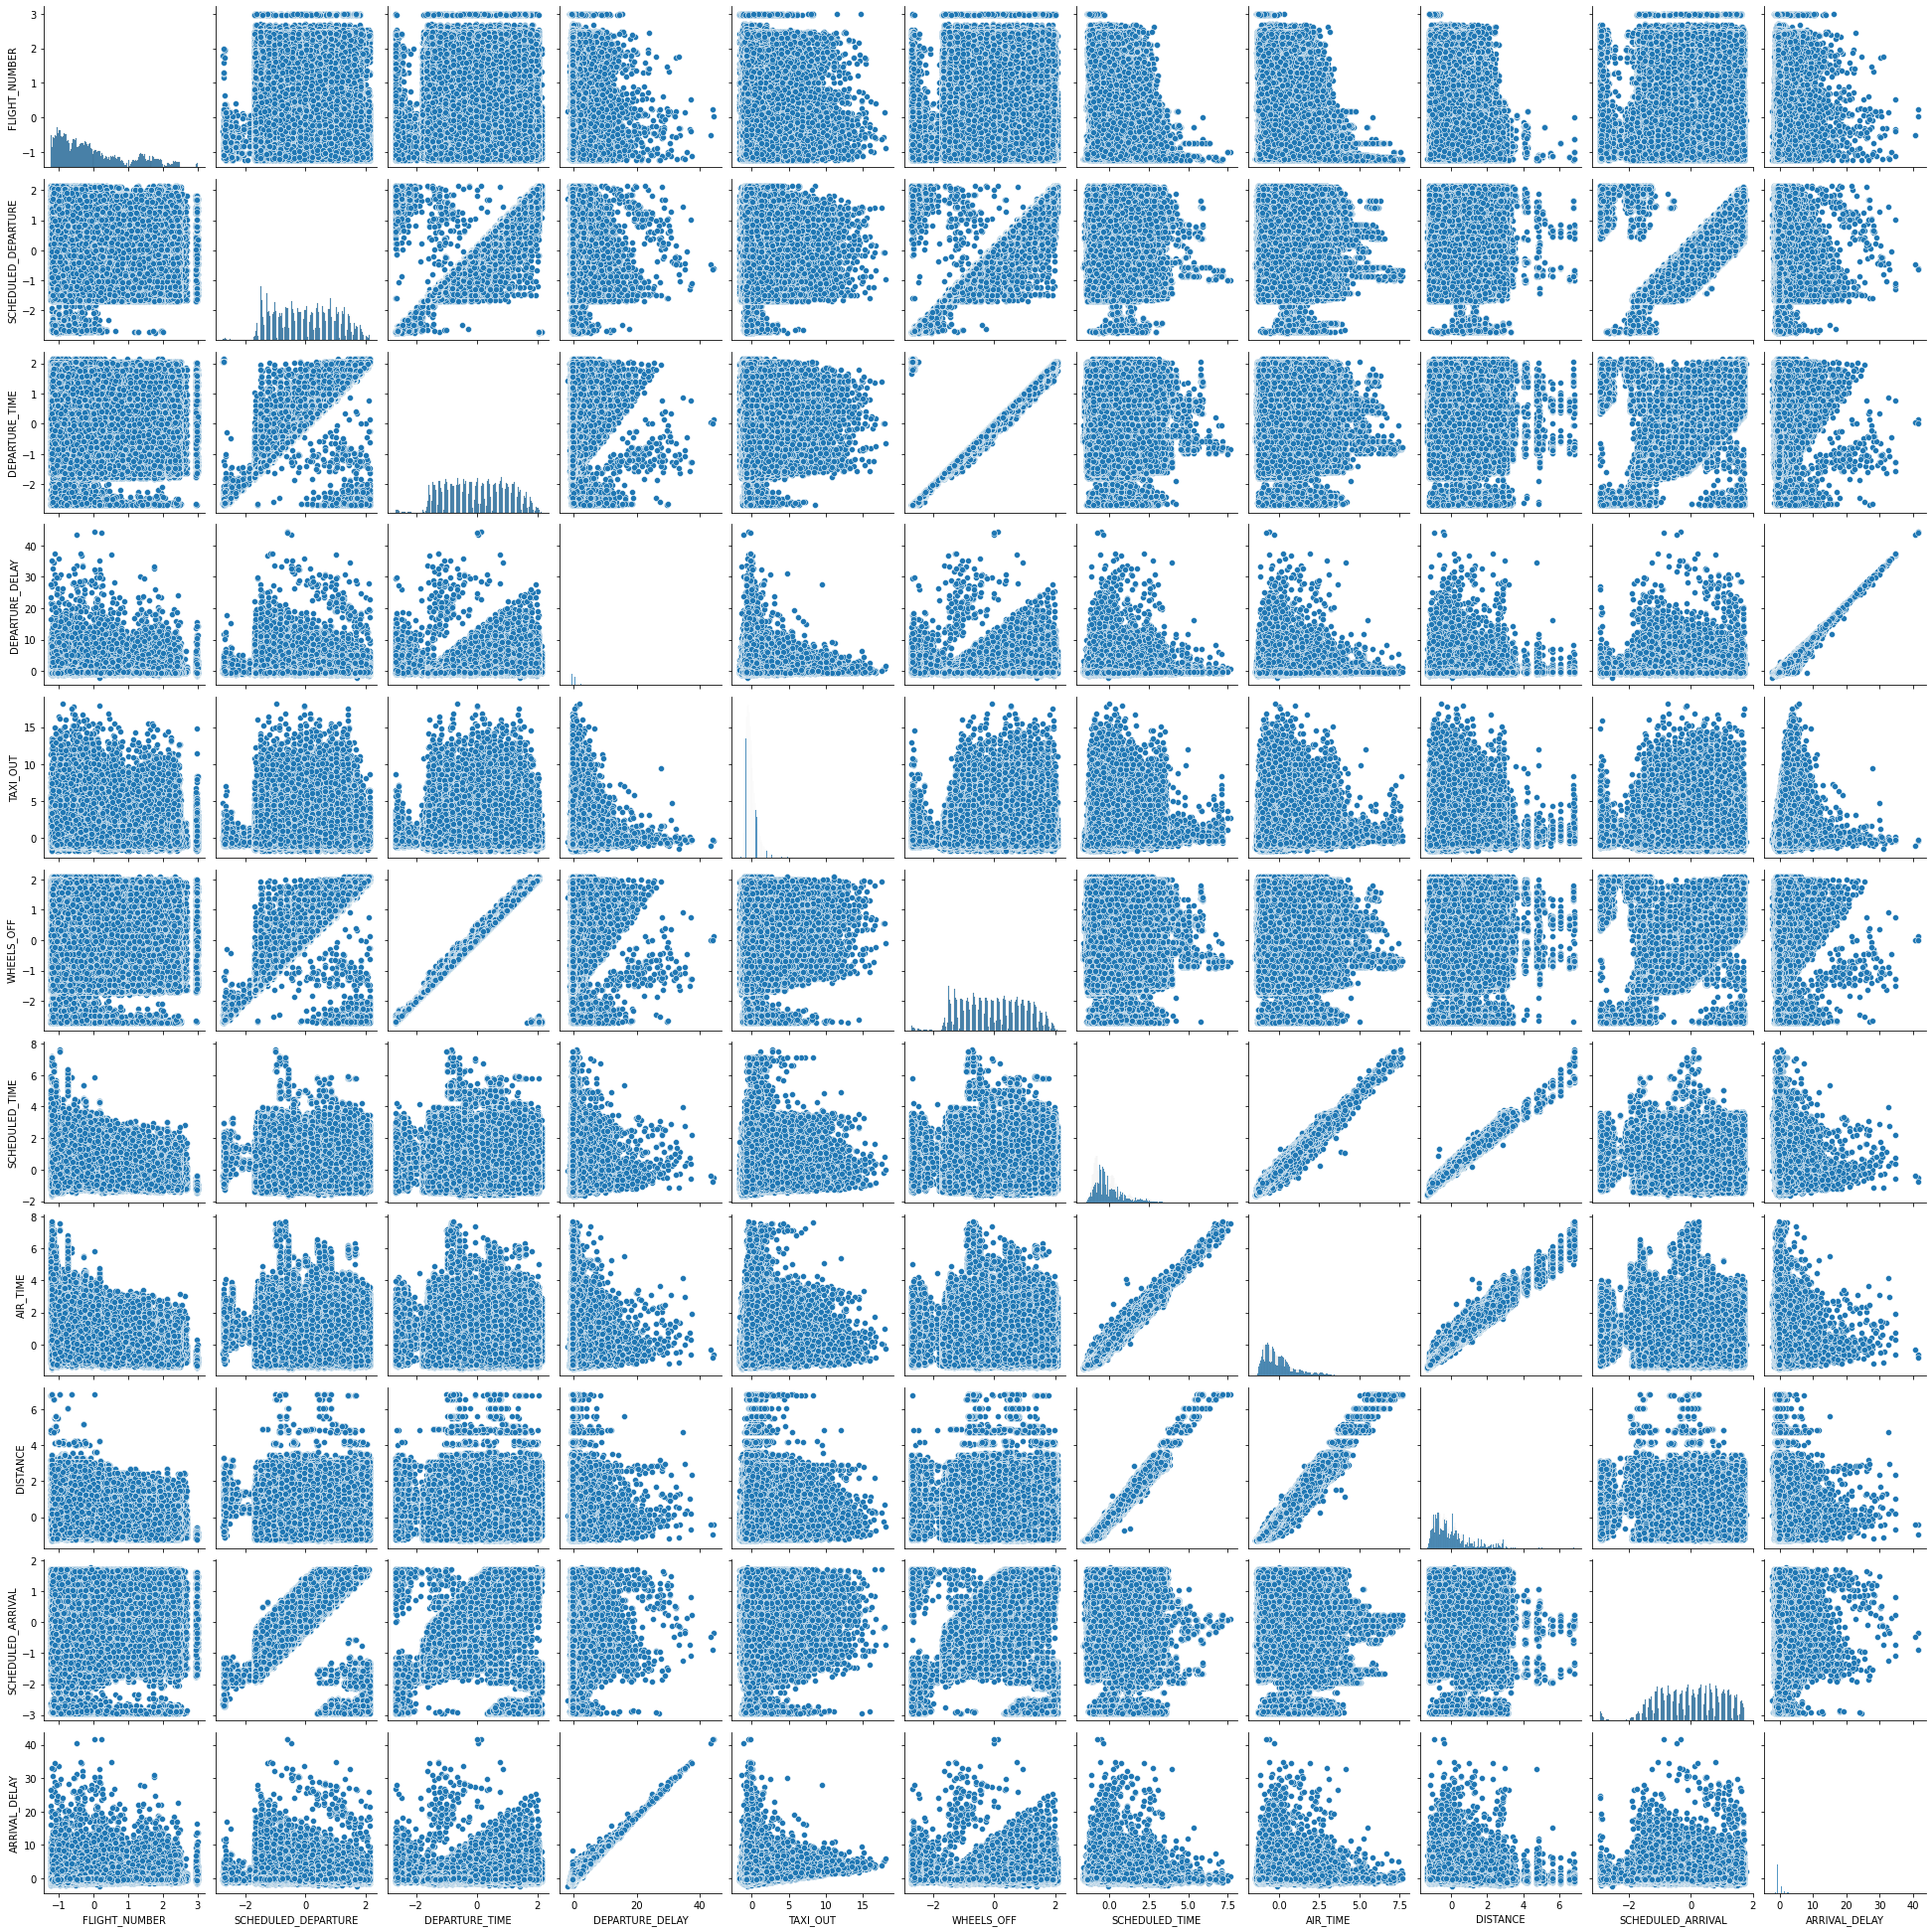

In [10]:
sns.pairplot(num_data[:1000000])

In [11]:
all_data.FLIGHT_NUMBER.value_counts().to_frame().head(10)

,FLIGHT_NUMBER
469,3642
327,3255
326,3228
403,3093
407,3085
667,3075
188,3064
315,3047
223,3014
761,3010


__FLIGHT_NUMBER__ is very random feature, which is normal, because it is __Flight Identifier (Not Sequntial)__ and we can see that it is not a continuos feature, it's a semi numerical but it takes too numerous values (~ 6100) so due to our material limitation, we cannot consider it as categorical. ==> Get rid of __FLIGHT_NUMBER__. 

As viewed with __correlation Matrix__, __Scatter plot__ shows us that there's relation between some features as (__WHEELS_OFF ,DEPARTURE_TIME__), (__SCHEDULED_TIME, AIR_TIME, DISTANCE__)

### 1.2. CATEGORICAL FEATURES

In [12]:
## we don't need To include CANCELLED as categorical features (same value for all)
all_data.CANCELLED.value_counts().to_frame()

,CANCELLED
0,5314008


In [13]:
## we don't need To include DIVERTED as categorical features (same value for all)
all_data.DIVERTED.value_counts().to_frame()

,DIVERTED
0,5314008


In [14]:
categorical_fts = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT']
print("Number of AIRLINE values is {}".format(len(all_data['AIRLINE'].unique())))
print("Number of ORIGIN_AIRPORT values is {}".format(len(all_data['ORIGIN_AIRPORT'].unique())))
print("Number of DESTINATION_AIRPORT values is {}".format(len(all_data['DESTINATION_AIRPORT'].unique())))
all_data[categorical_fts].head(10)

Number of AIRLINE values is 14
Number of ORIGIN_AIRPORT values is 628
Number of DESTINATION_AIRPORT values is 629


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,AA,BWI,DFW
1,WN,ONT,SMF
2,MQ,DFW,LCH
3,B6,BOS,LAS
4,WN,LAX,OAK
5,EV,LEX,ORD
6,OO,MTJ,ORD
7,OO,14869,10918
8,AA,MSY,CLT
9,AS,SAN,SEA


In [15]:
## MISSING VALUES 
data_cat = all_data[categorical_fts]
data_cat.isnull().sum().to_frame()

## NO MISSING VALUES

,0
AIRLINE,0
ORIGIN_AIRPORT,0
DESTINATION_AIRPORT,0


### Correlation Matrix 

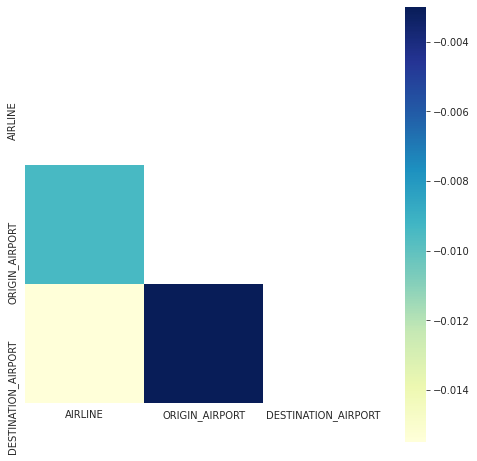

In [16]:
cat_corr = data_cat.apply(lambda x: x.factorize()[0]).corr()
mask = np.zeros_like(cat_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cat_corr, mask=mask, square=True, cmap="YlGnBu")
    
# There's almost no correlation between selected categorical features

The common idea with the categorical features is to use the One Hot Encoding, but here we have a problem, __DESTINATION_AIRPORT__, and __ORIGIN_AIRPORT__, have total distinct values of __1257__, which makes our data set very large. 

__Solution__ : Instead of working with airports, we can work with there Coordinates of airports given in AIRPORTS file, so :
> __DESTINATION_AIRPORT__ will be prensented by numerical features __LATITUDE_dst__, __LONGITUDE_dst__
> __ORIGIN_AIRPORT__ will be prensented by numerical features __LATITUDE_org__, __LONGITUDE_org__


In [17]:
def cata_to_num(data_src) :
    df = data_src
    df = pd.merge(df,analysis_airports[['IATA_CODE','LATITUDE','LONGITUDE']] ,how='left' , left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')
    df = df.rename(columns={'LATITUDE':'LATITUDE_org','LONGITUDE':'LONGITUDE_org'}).drop(['IATA_CODE'],axis=1)
    df = pd.merge(df,analysis_airports[['IATA_CODE','LATITUDE','LONGITUDE']] ,how='left' ,left_on='DESTINATION_AIRPORT', right_on='IATA_CODE')
    df = df.rename(columns={'LATITUDE':'LATITUDE_dst','LONGITUDE':'LONGITUDE_dst'}).drop(['IATA_CODE'],axis=1)
    return df

data_cat = cata_to_num(data_cat)
data_cat.head(5)

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,LATITUDE_org,LONGITUDE_org,LATITUDE_dst,LONGITUDE_dst
0,AA,BWI,DFW,39.17540,-76.66820,32.89595,-97.03720
1,WN,ONT,SMF,34.05600,-117.60119,38.69542,-121.59077
2,MQ,DFW,LCH,32.89595,-97.03720,30.12610,-93.22340
3,B6,BOS,LAS,42.36435,-71.00518,36.08036,-115.15233
4,WN,LAX,OAK,33.94254,-118.40807,37.72129,-122.22072


### 1.3 SEMI NUMERICAL || SEMI CATEGORICAL FEATURES

In [18]:
min_delay = train_label.ARRIVAL_DELAY.min()
mean_delay = train_label.ARRIVAL_DELAY.mean()
max_delay = train_label.ARRIVAL_DELAY.max() 

print("The min arrival delay is {}".format(min_delay))
print("The mean arrival delay is {}".format(mean_delay))
print("The max arrival delay is {}".format(max_delay))

The min arrival delay is -87.0
The mean arrival delay is 4.409019331547864
The max arrival delay is 1971.0


<AxesSubplot:ylabel='mean'>

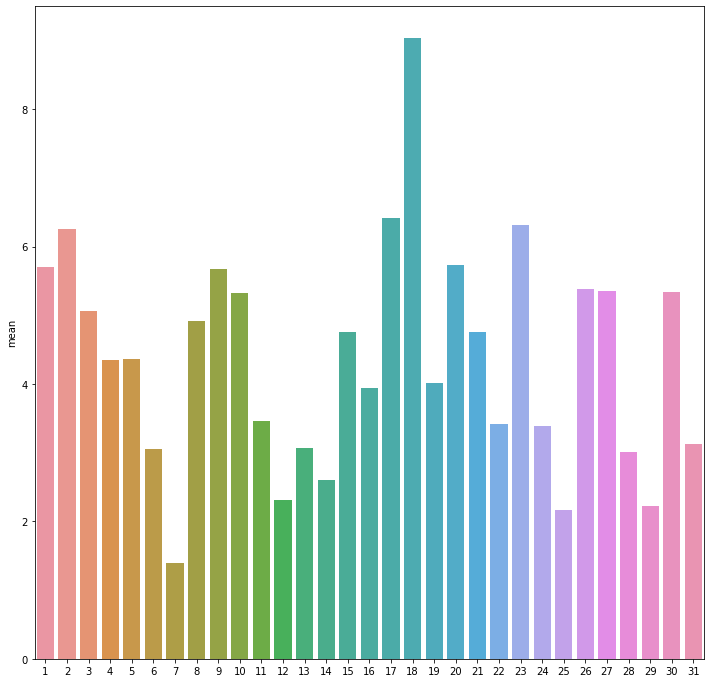

In [19]:
# Analyse Relation between day and delay 
days_delay = all_data.groupby('DAY').ARRIVAL_DELAY.agg(['mean'])
days = all_data.DAY.unique()

sns.barplot(np.sort(days),days_delay['mean'])

<AxesSubplot:ylabel='mean'>

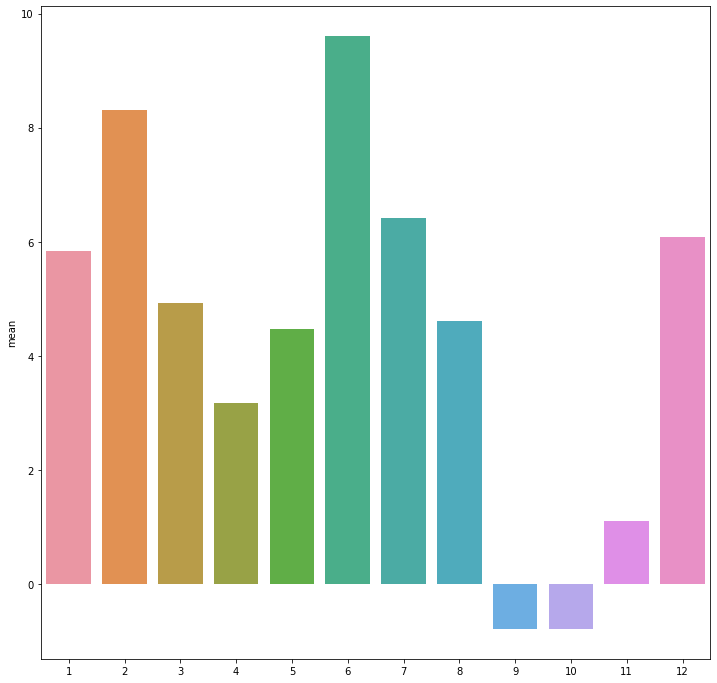

In [20]:
# Analyse Relation between month and delay
month_delay = all_data.groupby('MONTH').ARRIVAL_DELAY.agg(['mean'])
month = all_data.MONTH.unique()
sns.barplot(np.sort(month),month_delay['mean'])

<AxesSubplot:ylabel='mean'>

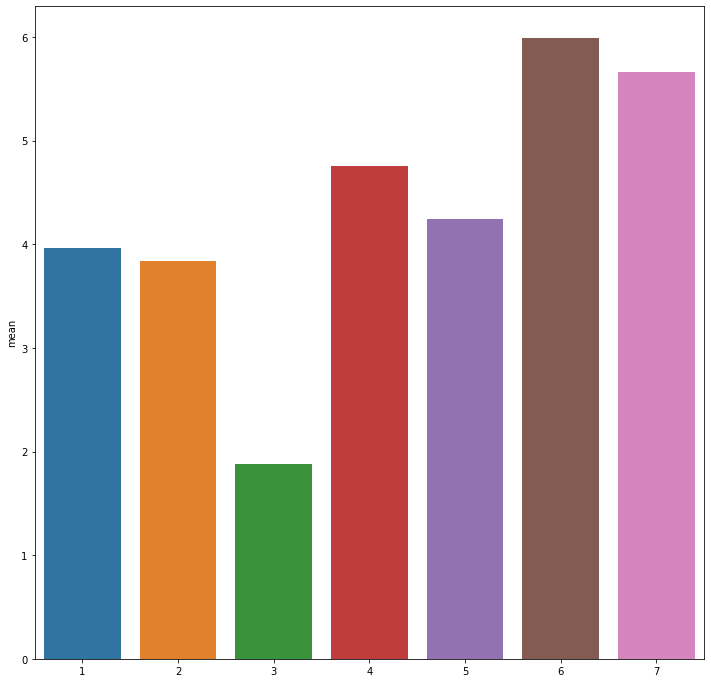

In [21]:
#analysing relation between day_of_week and the delay
day_w_delay = all_data.groupby('DAY_OF_WEEK').ARRIVAL_DELAY.agg(['mean'])
day_w = all_data.DAY_OF_WEEK.unique()
sns.barplot(day_w,day_w_delay['mean'])

We conclude that the arrival delay depends on the month, and on the day, according to the plots, a large average delay is completed during the end of the year period, and in summer (which can be explained by the increase in numbers of trips in these periods), and a significant variation in the arrival delay compared to the day, and the increase of the delay is seen in week-end days.

The limitation of the material, forces us to use these features when the prediction model allows it. because the one hot encoding results in 50 addtive features. 

In [22]:
def processing(data_df,data_ref,num_fts,cat_fts) :
    df_copy = data_df
    df_copy = fill_nan(df_copy,num_fts)
    normalize(df_copy,data_ref,num_fts)
    return df_copy

class pre_processing() :
    
    def __init__(self,data_df,data_ref,num_fts,cat_fts) :
        self.data_df = data_df
        self.data_ref = data_ref
        self.num_fts = num_fts
        self.cat_fts = cat_fts 
    
    def pre_process(self) :
        return processing(self.data_df,
                          self.data_ref,
                          self.num_fts,
                          self.cat_fts)
    
    def add_label(self,_data_df,_data_ref) :
        _data_df = pd.concat([_data_df,_data_ref.ARRIVAL_DELAY],axis=1)
        return _data_df
        
    def add_id(self,_data_df,_data_ref) :
        _data_df = pd.concat([_data_ref.ID,_data_df],axis=1)
        return _data_df

In [23]:
num_ft_selected = ['DEPARTURE_DELAY','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','SCHEDULED_TIME','DEPARTURE_TIME','TAXI_OUT','WHEELS_OFF','AIR_TIME','DISTANCE','LATITUDE_dst','LATITUDE_org','LONGITUDE_dst','LONGITUDE_org']
cat_ft_selected = [] ## AIRLINE will be done separtly 
all_fts = num_ft_selected + cat_ft_selected

In [24]:
train_data = cata_to_num(all_data)
y_data = train_data['ARRIVAL_DELAY']
test_data = cata_to_num(test_ft)

In [25]:
train_preprocess = pre_processing(train_data[all_fts],train_data[all_fts],num_ft_selected,cat_ft_selected)
print("pass create object")
train_df = train_preprocess.pre_process()
print("pass function pre_process")
df_cat = pd.get_dummies(train_data['AIRLINE'], dummy_na=False, drop_first=True)
train_df = pd.concat([train_df,df_cat],axis=1)
print("#####################################################################################")

test_preprocess = pre_processing(test_data[all_fts],train_data[all_fts],num_ft_selected,cat_ft_selected)
print("pass create object")
test_df = test_preprocess.pre_process()
print("pass function pre_process")
df_cat_test = pd.get_dummies(test_data['AIRLINE'], dummy_na=False, drop_first=True)
test_df = pd.concat([test_df,df_cat_test],axis=1)

pass create object
pass function pre_process
#####################################################################################
pass create object
pass function pre_process


In [26]:
train_df.head(10)

,DEPARTURE_DELAY,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,AIR_TIME,DISTANCE,LATITUDE_dst,...,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,-0.495990,-1.029683,-0.746108,1.090174,-1.033458,-0.682977,-1.054408,0.754324,0.644953,-0.620086,...,0,0,0,0,0,0,0,0,0,0
1,-0.197789,-0.824930,-0.874343,-0.821889,-0.811867,-1.020784,-0.839548,-0.671697,-0.713866,0.344751,...,0,0,0,0,0,0,0,0,0,1
2,-0.414663,1.822382,1.637094,-0.914836,1.750537,-0.457772,1.724716,-0.851680,-0.869958,-1.080896,...,0,0,0,1,0,0,0,0,0,0
3,0.019084,1.398399,1.607501,2.935846,1.369802,0.105240,1.355237,2.983348,2.557486,-0.090307,...,0,0,0,0,0,0,0,0,0,0
4,0.805251,0.839981,0.703936,-0.888280,0.964894,-0.908181,0.933549,-0.823990,-0.800949,0.182689,...,0,0,0,0,0,0,0,0,0,1
5,-0.116462,-1.507440,-1.695048,-0.635994,-1.470598,-0.570374,-1.488144,-0.754766,-0.823952,0.891128,...,1,0,0,0,0,0,0,0,0,0
6,-0.523099,-0.235489,0.216643,0.346594,-0.261917,-0.457772,-0.281313,0.297444,0.421495,0.891128,...,0,0,0,0,0,1,0,0,0,0
7,-0.631536,-1.052433,-1.150542,-1.220235,-1.065690,1.231265,-1.052400,-1.114733,-0.991545,0.000000,...,0,0,0,0,0,1,0,0,0,0
8,-0.360444,1.026120,1.226741,-0.423542,0.978995,-0.795579,0.949613,-0.464024,-0.285025,-0.234439,...,0,0,0,0,0,0,0,0,0,0
9,-0.387554,0.240199,0.467194,0.306760,0.211483,-0.232567,0.194592,0.269754,0.370560,1.801049,...,0,0,0,0,0,0,0,0,0,0


In [27]:
test_df.head(10)

,DEPARTURE_DELAY,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,AIR_TIME,DISTANCE,LATITUDE_dst,...,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,-0.333335,-0.618109,-0.665221,-0.742219,-0.620492,0.217843,-0.626696,-0.699387,-0.741799,0.344751,...,0,0,0,0,0,1,0,0,0,0
1,-0.414663,-0.016259,0.072625,-0.171256,-0.040326,-0.682977,-0.064445,0.075926,-0.110860,0.403099,...,0,0,0,0,0,0,0,0,0,0
2,-0.116462,1.812041,1.607501,-0.250925,1.762623,0.330445,1.750820,-0.339420,-0.358963,0.891128,...,0,0,0,0,0,0,0,0,0,0
3,-0.360444,-0.266513,-0.367321,-0.994505,-0.360626,-0.457772,-0.299386,-0.976284,-1.014548,1.350606,...,1,0,0,0,0,0,0,0,0,0
4,-0.360444,-1.505372,-0.688895,1.076896,-1.567292,-0.119964,-1.496176,1.141981,1.331756,-1.105124,...,0,0,0,0,0,0,1,0,0,0
5,1.347434,0.974415,1.049185,0.041195,1.055545,-0.682977,1.108248,0.214375,0.041946,-0.628211,...,0,0,0,0,0,0,0,0,0,1
6,4.681864,0.858595,1.007755,0.771497,1.432251,1.231265,1.517888,0.657410,0.630165,-1.105124,...,0,0,0,0,0,0,1,0,0,0
7,0.046193,-0.680155,-0.726379,-0.755497,-0.652724,-0.682977,-0.674889,-0.685542,-0.741799,-0.445968,...,0,0,0,0,0,0,0,0,0,1
8,-0.306226,1.201918,1.299737,0.266925,1.154254,-0.119964,1.136361,0.200530,0.212825,1.801049,...,0,0,0,0,0,0,0,0,0,0
9,-0.143571,1.263965,1.088642,-0.224369,1.226775,-0.570374,1.200618,-0.284041,-0.285025,0.538234,...,0,0,0,0,0,0,0,0,0,1


### 2. Models Preparation 

In [28]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


In [29]:
X_train_df = train_df[:12000] ## Training Set Tuning 
y_train_df = y_data[:12000]
X_test_df = test_df

In [30]:
# First of all, you should split the data into a training set and a validation set
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, random_state=1, test_size=0.2)

In [31]:
class create_model() :
    def __init__(self, model, batch_size=100) :
        self.model = model
        self.batch_size = batch_size 
    
    def make_prediction(self,X) :
        X_len= len(X)
        range_predict= [(i*X_len)//self.batch_size for i in range (1, self.batch_size +1) ]
        y_pred= self.model.predict(X[:range_predict[0]])
        for i in range (1,len(range_predict)):
            y_pred_i= self.model.predict(X[range_predict[i-1]:range_predict[i]])
            y_pred = np.concatenate((y_pred, y_pred_i),axis=0)
        return y_pred
    
    def mmse_score(self,X,Y) :
        return np.sqrt(mean_squared_error(self.make_prediction(X), Y.values))
    
    def make_submission(self,X_test_df_,name) :
        y_test_pred = self.make_prediction(X_test_df_)
        submission_df = pd.DataFrame(data={'ID': test_ft.ID.values,'ARRIVAL_DELAY': y_test_pred.squeeze()})
        submission_df.to_csv("/kaggle/working/submission{}.csv".format(name), index=False)
        return "DONE"


# Define validation function
n_folds = 5

def rmsle_cv(model,X_train,y_train):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    score = np.mean(rmse)
    return(score)

### a. Polynomial Regression degree = 2

In [32]:
# Parametric Models 
# Polynomial : degree 2
from sklearn.pipeline import make_pipeline
polyReg = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])
polyReg.fit(X_train_df, y_train_df)
polyRegModel = create_model(polyReg)
valMMSE = polyRegModel.mmse_score(X_val_df,y_val_df)
trainMMSE = polyRegModel.mmse_score(X_train_df,y_train_df)


print("TRAIN SET MSE  is {}".format(trainMMSE))
print("Validation SET MSE is {}".format(valMMSE))

TRAIN SET MSE  is 5.134160312974738
Validation SET MSE is 5.5857247515619095


In [33]:
crossVal = rmsle_cv(polyReg,X_train_df,y_train_df)
print("Cross Validation Score is {}".format(crossVal))

Cross Validation Score is 6.362955332495405


### b. Gaussian Process Regressor 

In [34]:
## Gaussian Process 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel


kernel = DotProduct() + WhiteKernel()
GPR = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train_df, y_train_df)
GPR_model = create_model(GPR)

In [35]:
valMMSE = GPR_model.mmse_score(X_val_df,y_val_df)
trainMMSE = GPR_model.mmse_score(X_train_df,y_train_df)

print("TRAIN SET MSE  is {}".format(trainMMSE))
print("Validation SET MSE is {}".format(valMMSE))

TRAIN SET MSE  is 6.040949714459578
Validation SET MSE is 6.016736085358765


In [36]:
crossVal = rmsle_cv(GPR,X_train_df[:10000],y_train_df[:10000])
print("Cross Validation Score is {}".format(crossVal))

Cross Validation Score is 6.385336708787255


### c. Elastic NET 

In [37]:
## ElasticNet
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet.fit(X_train_df, y_train_df)
ENetModel = create_model(ENet)
valMMSE = ENetModel.mmse_score(X_val_df,y_val_df)
trainMMSE = ENetModel.mmse_score(X_train_df,y_train_df)

print("TRAIN SET MSE  is {}".format(trainMMSE))
print("Validation SET MSE is {}".format(valMMSE))

TRAIN SET MSE  is 5.352519057438606
Validation SET MSE is 5.265486588112975


In [38]:
crossVal = rmsle_cv(ENet,X_train_df,y_train_df)
print("Cross Validation Score is {}".format(crossVal))

Cross Validation Score is 5.35291883357269


### d. Random Forest Regressor 

In [39]:
#Random Forest regressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_df,y_train_df)
FRModel = create_model(forest_reg)
valMMSE = FRModel.mmse_score(X_val_df,y_val_df)
trainMMSE = FRModel.mmse_score(X_train_df,y_train_df)

In [40]:
print("TRAIN SET MSE  is {}".format(trainMMSE))
print("Validation SET MSE is {}".format(valMMSE))

TRAIN SET MSE  is 4.052338973512705
Validation SET MSE is 9.399881969560399


In [41]:
crossVal = rmsle_cv(forest_reg,X_train_df,y_train_df)
print("Cross Validation Score is {}".format(crossVal))

Cross Validation Score is 11.357064541500755


### e. KERNEL Ridge Regressor  (Polynomial Kernel)

In [42]:
# Kernel Ridge 
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(X_train_df, y_train_df)
KRRModel = create_model(KRR)
valMMSE = KRRModel.mmse_score(X_val_df,y_val_df)
trainMMSE = KRRModel.mmse_score(X_train_df, y_train_df)

print("TRAIN SET MSE  is {}".format(trainMMSE))
print("Validation SET MSE is {}".format(valMMSE))

TRAIN SET MSE  is 5.238967581080686
Validation SET MSE is 5.257191206782958


In [43]:
crossVal = rmsle_cv(KRR,X_train_df[:10000], y_train_df[:10000])
print("Cross Validation Score is {}".format(crossVal))

Cross Validation Score is 5.342848102860676


### 3. Model Selection 
Good Models based on Cross Validation : ElasticNet , Kernel Ridge Regressor
Random Forest seems to predict well sometimes, and give us good mse score but it almost overfits. 

##### First Idea of Improvement : 
Averaged base models, use the out-of-folds predictions of these base models to train an average model.
The procedure, for the training part, may be described as follows:

1. Train several base models on train Dataset 
2. Predict using Cross Validation Prediction
3. Use those predictions as inputs of another prediction model (output is y_train)

### 3.1. Average Model ENet and Kernel Ridge Regressor

In [44]:
## Average Model

from sklearn.model_selection import cross_val_predict

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=3, coef0=2.5)

ENetModel = create_model(ENet)
KRRModel = create_model(KRR)

models_selected = ["ENet","KRR"] ## Models with High Cross Validation Score Selected 

## Predicted Using Cross Validation Prediction
y_pred_ENet = cross_val_predict(ENet,X_train_df,y_train_df,cv=5)
y_pred_KRR = cross_val_predict(KRR,X_train_df,y_train_df,cv=5)


In [45]:
# Make last predictions as inputs, and try to fit a model to find a mapping between 
# those predictions and y_train (AVERAGE MODEL)
# We are going to use Lasso Model with robust scaler

lasso = Lasso(alpha =0.0005, random_state=1)
lasso.fit(np.array([y_pred_ENet,y_pred_KRR]).T, y_train_df)

LassoModel = create_model(lasso)
trainMMSE = LassoModel.mmse_score(np.array([y_pred_ENet,y_pred_KRR]).T,y_train_df)

In [46]:
print("Train Mse Based on AVERAGE Model is {}".format(trainMMSE))

Train Mse Based on AVERAGE Model is 5.345867348007853


In [47]:
y_pred_ENet_val = ENet.fit(X_train_df,y_train_df).predict(X_val_df)   
KRR.fit(X_train_df,y_train_df)
y_pred_KRR_val = KRR.predict(X_val_df)

valMMSE = LassoModel.mmse_score(np.array([y_pred_ENet_val,y_pred_KRR_val]).T,y_val_df)
print("Validation Mse Based on AVERAGE Model is {}".format(valMMSE))

Validation Mse Based on AVERAGE Model is 5.230626856992105


In [48]:
print("Validation Mse Based on AVERAGE Model is {}".format(valMMSE))

Validation Mse Based on AVERAGE Model is 5.230626856992105


In [49]:
cross_Val = rmsle_cv(lasso,np.array([y_pred_ENet,y_pred_KRR]).T,y_train_df)
print("Cross Validation Score of Average Model is {}".format(cross_Val))

Cross Validation Score of Average Model is 5.342530207340761


In [50]:
X_train_df_large = train_df[:200000] ## Training Set Tuning 
y_train_df_large = y_data[:200000]
X_test_df = test_df

X_train_df_large, X_val_df_large, y_train_df_, y_val_df_ = train_test_split(X_train_df_large, y_train_df_large, random_state=1, test_size=0.2)

### 3.2. Elastic Net with Polynomial Features

In [51]:
# Elastic Net with Polynomial Features 

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
poly = PolynomialFeatures(degree=2).fit_transform(X_train_df_large)
ENet.fit(poly, y_train_df_)
ENetModel = create_model(ENet)
valMMSE = ENetModel.mmse_score(PolynomialFeatures(degree=2).fit_transform(X_val_df_large),y_val_df_)
trainMMSE = ENetModel.mmse_score(poly, y_train_df_)

print("TRAIN SET MSE  is {}".format(trainMMSE))
print("Validation SET MSE is {}".format(valMMSE))

TRAIN SET MSE  is 5.299482091933316
Validation SET MSE is 5.115075200766473


In [52]:
crossVal = rmsle_cv(ENet,X_train_df[:100000], y_train_df[:100000])
print(crossVal)

5.35291883357269


### SELECTED MODEL : Average model of Enet and KRR VS Polynomial ENet. 
The Enet with polynomial features gives the best result in terms of training, validation and test RMSE. However to be used this model needs a training dataset of 200000 samples whereas the kernel Ridge Regressor offers similar results trained on 10000 samples. To conclude we choose the ENet with polynomial features of degree 2 for this challenge as we have a large amount of data and because the RMSE result is the best but Kernel Ridge Regressor would be a better model in the case of a smaller dataset.


### DEEP NEURAL NETWORK 
- We implemented this modele using __Tensorflow Addons__

- For this model we used the __NovoGrad Optimizer__ which uses gradient descent method with __layer-wise gradient normalization__ and __decoupled weight decay__.

- Add a __droup out__ to face the overfitting 

- Use __exponential decrease cyclical learning rate__ scheduler 

- We train the model using __leaky ReLU__ activation 

- __Batchnormalisation__ to make loss function smoother

- All these addons allow us to train a decent DNN with minimal hyperparameter tuning especially for learning rate.

- ___N.B : It takes a lot of time to run the DNN Code, if you want to test, please uncoment the code___

In [53]:
# Deep Neural Network 
#! pip install optuna
#! pip install tensorflow_addons
#import tensorflow 
#import tensorflow.keras as keras
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#import optuna
#import tensorflow_addons as tfa
#from tensorflow.keras.layers import Dropout , BatchNormalization 
#from tensorflow.nn import leaky_relu
#from tensorflow.keras import backend as K
#from tensorflow_addons.optimizers.novograd import NovoGrad

In [54]:
#model = Sequential()
#n_cols = X_train_df.shape[1]
#print("N_cols=",n_cols)

#def rmse(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
#def LR(x):
#    return leaky_relu(x, alpha=0.1)

#model.add(Dense(300, activation=LR, input_shape= (n_cols,)))
#model.add(BatchNormalization())
#model.add(Dropout(0.15))
#model.add(Dense(300, activation=LR))
#model.add(BatchNormalization())
#model.add(Dropout(0.1))
#model.add(Dense(320, activation=LR))
#model.add(BatchNormalization())
#model.add(Dropout(0.1))
#model.add(Dense(350, activation=LR))
#model.add(BatchNormalization())
#model.add(Dense(200, activation=LR))
#model.add(BatchNormalization())
#model.add(Dense(200, activation=LR))
#model.add(BatchNormalization())
#model.add(Dense(1))

#lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
#            initial_learning_rate=1e-4,
#            maximal_learning_rate=1e-2,
#            step_size=2000,
#            scale_mode="cycle",
#            gamma=0.96,
#            name="MyCyclicScheduler")

# Optimizer

#opt = NovoGrad(learning_rate=lr_schedule)
#opt = tfa.optimizers.Lookahead(opt) ##WRAP OPTIMIZER WITH LookAhead layer 
##Early stopping
#es =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, #patience=200)

In [55]:
#model.compile(optimizer=opt, loss=rmse)
# train model
#history = model.fit(X_train_df, y_train_df, verbose=0, batch_size=40,validation_split=0.2, #epochs=1000, callbacks=[es])
 
# list all data in history
#print(history.history.keys())

In [56]:
def make_prediction(X, model):
    y_pred = model.predict(X)
    return y_pred

In [57]:
#y_val_pred = make_prediction(X_val_df, model)
#val_rmse = np.sqrt(mean_squared_error(y_val_pred, y_val_df.values))
#print("VAL RMSE: {:.5f}".format(float(val_rmse)))
#y_train_pred = make_prediction(X_train_df, model)
#train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train_df.values))
#print("Train RMSE: {:.5f}".format(float(train_rmse)))

#### VAL RMSE: 7.51688

#### Train RMSE: 7.82663

## Conclusion 

Thus, with correct feature selection and less complex models chosen by us, we find that ENet with Polynomial Features degree 2 and Kernel Ridge Regressor predicts the air delay better considering the RMSE and Cross validation score. Further, if given some more time, we would have tried to optimize the hyperparameters of the models, optimise the RAM utilisation and would have tried a few more stacked average models to improve the performance of the model.

We tried different kinds of models, deep neural network one, non parametric ones and simple linear regression to finally choose the ENet with polynomial features and we submit the scores of both this model and the KRR model.